# 1. Import Packages

In [1]:
# Data Structure
import numpy as np
import pandas as pd
# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
# Classifier
from sklearn.ensemble import RandomForestClassifier
# Metrics
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
# Explainable Artificial Intelligence (XAI)
import shap
# Preprocessing
from utils import DataHandler

/Users/martinwohlan/opt/miniconda3/envs/XAI/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This notebook provides a concrete example of the explanation from SHAP. The chosen dataset is decribed in detail in the descriptive_analysis notebook contained in the repository. As the complex model a random forest classifier with default parameters is chosen. Since the aim of this work is to show which explanations are provided by SHAP and how they are visualized the complex model was was further optimized in terms of hyperparameters.
Target is to predict the probability of a person having a stroke. In section 2 the data preprocessing for the complex model is executed. Section 3 contains the fitting of the classifier and section 4 the explanation of SHAP which is further divided into local and global explanation.

# 2. Data Preparation

The whole data preparation process is outsourced to the utils.py file contained in the repository. Thus, to get detailed information on the conducted preprocessing have a look at the utils.py file.

In [2]:
data_handler = DataHandler()

In [3]:
data_handler.load_data('healthcare-dataset-stroke-data.csv')

In [4]:
data_handler.preprocess()

In [5]:
data_handler.get_dummies()

In [6]:
X_train, X_test, y_train, y_test = data_handler.split_data()

In [7]:
X_train_resample,y_train_resample = data_handler.oversample(X_train, y_train)

# 3. Prediction Model (Random Forest Classifier)

Random forest classifier is fitted with all default parameters.

In [8]:
# Random Forest Classifier object
rf = RandomForestClassifier(random_state=42)
# Train the model
rf.fit(X_train_resample, y_train_resample)

RandomForestClassifier(random_state=42)

In [9]:
# Predictions for test data
y_pred = rf.predict(X_test)

In [10]:
# Metrics
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}") # macro: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
print(f"Accuracy {accuracy_score(y_test, y_pred)}")

F1 Score 0.49822864150429214
Accuracy 0.9456890699253224


In [11]:
y_test.value_counts()

0    1401
1      72
Name: stroke, dtype: int64

In [12]:
confusion_matrix(y_test, y_pred, labels=[1, 0])

array([[   1,   71],
       [   9, 1392]])

The model only predicts stroke for one instance which is not good when the aim is to predict stroke. But the aim of this work is not building a good model.

In [13]:
# ratio of stroke to no stroke
1-72/1473

0.9511201629327902

Always predicting 'No Stroke' would be better than the model.
But also consider that the model was trained on a resampled dataset containing an equal number of 'Stroke' and 'No Stroke' instances.

In [14]:
# Predict the probability of a patient having  no stroke (index 0) and stroke (index 1)
rf.predict_proba(X_test)

array([[0.7 , 0.3 ],
       [0.97, 0.03],
       [0.95, 0.05],
       ...,
       [0.92, 0.08],
       [1.  , 0.  ],
       [0.84, 0.16]])

RandomForestClassifier is fitted with all default parameters

# 4. Explaining Predictions with SHAP

Similar to Molnar (2022) the faster TreeSHAP estimation method is used instead of the slower KernelSHAP method. As we pass the argument model_output = "raw" Shapley values are computed. 
It is important the results only describe the behavior of the complex mode. Therefore the effects shown below do not necessarily provide causality in the real world.

In [15]:
# calculate Shapley Values for the test data
explainer = shap.Explainer(rf, model_output = "raw") 

The calculation of the Shapley values for every instance can take some time. For my laptop it takes round about 20 seconds for the whole testing dataset.

In [16]:
# calculate Shapley Values for the test data
shap_values = explainer.shap_values(X_test)

Since we run SHAP on every instance of the test dataset we got a matrix of shap values:

In [17]:
shap_values

[array([[-0.09715435,  0.01509737, -0.10522272, ...,  0.01278264,
          0.03376114,  0.01782802],
        [ 0.23099817,  0.01406923,  0.00524007, ...,  0.00101872,
          0.00339724,  0.00699355],
        [ 0.07196706, -0.06828946,  0.01989816, ...,  0.01469557,
          0.03410448,  0.01109181],
        ...,
        [-0.01582432,  0.02292808,  0.01733605, ...,  0.02961236,
          0.00795482,  0.00930689],
        [ 0.2361258 ,  0.01002914,  0.00847169, ...,  0.01360767,
          0.02046293,  0.00573749],
        [ 0.04860343,  0.0169983 ,  0.02076867, ...,  0.01976892,
         -0.00398356,  0.00927807]]),
 array([[ 0.09715435, -0.01509737,  0.10522272, ..., -0.01278264,
         -0.03376114, -0.01782802],
        [-0.23099817, -0.01406923, -0.00524007, ..., -0.00101872,
         -0.00339724, -0.00699355],
        [-0.07196706,  0.06828946, -0.01989816, ..., -0.01469557,
         -0.03410448, -0.01109181],
        ...,
        [ 0.01582432, -0.02292808, -0.01733605, ..., -

In [18]:
shap_values[1].shape

(1473, 21)

In [19]:
# The shape of shap_values can be understood as: shap_values[ 0 = no stoke or 1 = stroke][index of instance to be explained]
# shapley values for first class 'no stroke' (=0) of the first instance (index=0)
shap_values[0][0]

array([-9.71543506e-02,  1.50973650e-02, -1.05222718e-01,  1.24919886e-01,
        1.13983192e-01, -5.86694128e-03, -1.48111368e-02, -3.06806815e-07,
       -1.90288208e-02, -1.51257833e-02,  8.19305193e-03, -1.64372964e-05,
       -5.03804334e-04, -1.14568983e-02, -3.16374407e-03,  1.42614349e-02,
        2.13652580e-02,  1.09846736e-01,  1.27826442e-02,  3.37611400e-02,
        1.78280182e-02])

In [20]:
# shapley values for second class 'stroke' (=1) of the first instance (index=0)
shap_values[1][0]

array([ 9.71543506e-02, -1.50973650e-02,  1.05222718e-01, -1.24919886e-01,
       -1.13983192e-01,  5.86694128e-03,  1.48111368e-02,  3.06806815e-07,
        1.90288208e-02,  1.51257833e-02, -8.19305193e-03,  1.64372964e-05,
        5.03804334e-04,  1.14568983e-02,  3.16374407e-03, -1.42614349e-02,
       -2.13652580e-02, -1.09846736e-01, -1.27826442e-02, -3.37611400e-02,
       -1.78280182e-02])

In [21]:
explainer.expected_value # The base values of class 'no stroke' and 'stroke' in the training data set which were resampled.

array([0.50031222, 0.49968778])

## 4.1 Explain Individual Predictions

In [22]:
# instance to be explained
X_test[0:1]

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
4336,80.0,0,1,125.32,32.9,0,1,0,0,1,...,0,1,0,0,1,0,1,0,0,0


In [23]:
prediction = rf.predict(X_test[0:1])
print(f"The RF predicted: {prediction}")

The RF predicted: [0]


In [24]:
# create dataframe with shapley values of the feature for the first instance of the test data
feature_and_shap_values = pd.DataFrame({'features':rf.feature_names_in_, 'shap_values':shap_values[1][0]})

In [25]:
feature_and_shap_values.sort_values(by='shap_values', ascending=False)

,features,shap_values
2,heart_disease,1.052227e-01
0,age,9.715435e-02
8,ever_married_No,1.902882e-02
9,ever_married_Yes,1.512578e-02
6,gender_Male,1.481114e-02
13,work_type_Self-employed,1.145690e-02
5,gender_Female,5.866941e-03
14,work_type_children,3.163744e-03
12,work_type_Private,5.038043e-04
11,work_type_Never_worked,1.643730e-05


In [26]:
# local explanation for the first instance
shap.force_plot(explainer.expected_value[1], shap_values[1][0], feature_names = rf.feature_names_in_)

Note: For the shap_values argument: If this is a 1D array then a single force plot will be drawn, if it is a 2D array then a stacked force plot will be drawn.

**Description**: The explanation provided by the force_plot function shows the Shapley values of the respective features. Starting from the base value the values the features are summed up to the output of the complex model. The red features increase and the blue features decrease the predicted probability.

**Interpretation**: The base value is the average predicted probability of having a stroke in the training data. Starting from the base value each features can be seen as a "force" that pushes the prediction to the prediction of the complex model (= 0.3). The values can be understood as the average contribution of respective feature in different coalitions of the features. For the age feature this means: given the current set of concrete feature values, the contribution of being 80 years to the difference between the predicted probability of 0.3 and the mean prediction in the training dataset (=base value) is about 0.11. The same interpretation applies for the other values.

## 4.2 Global Explanations

## 4.2.1 Feature Importance

In order to generate a global explanation the absolute Shapley values computed for every instance in the testing dataset are averaged. Afterwards the features with a higher average can be interpreted as imporant.

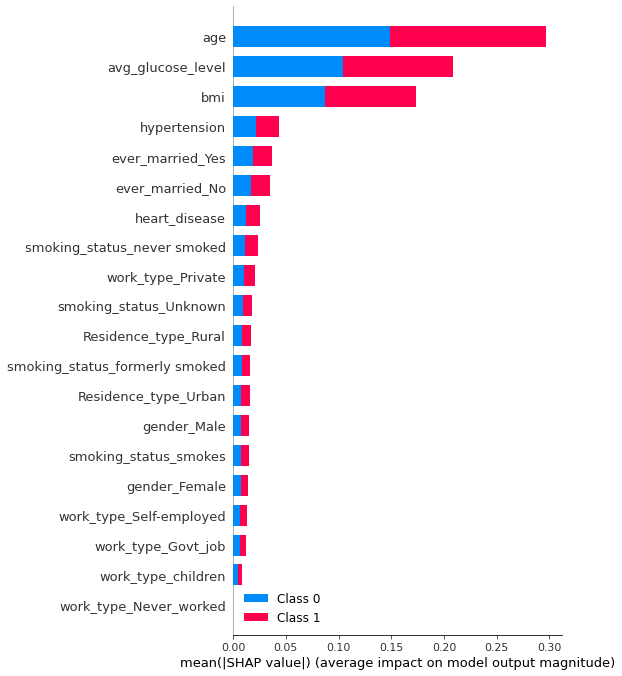

In [27]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

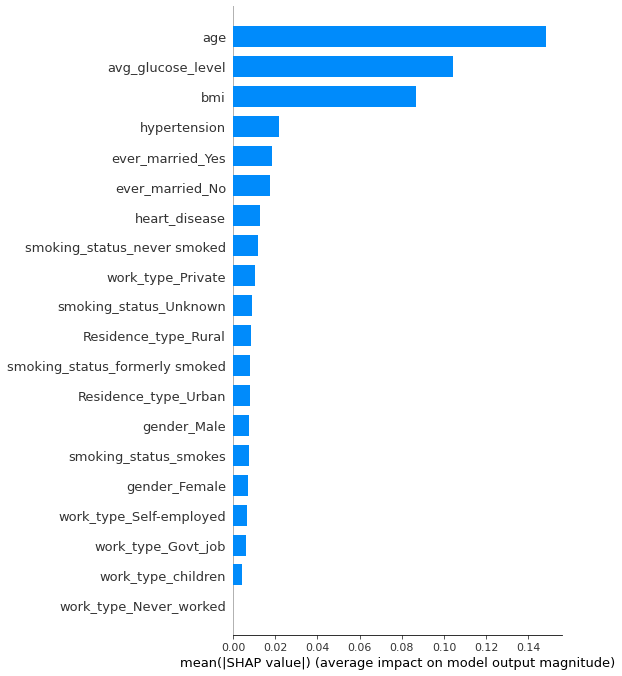

In [28]:
shap.summary_plot(shap_values[1], X_test, plot_type="bar")

**Description**: The both visualzations above show the average of the absolute Shapley values for each feature in the testing dataset. The respective computed values are in descending order.

In [29]:
# mean SHAP value over all instances for the 'age' feature.
np.mean(np.abs([i[0] for i in shap_values[1]]))

0.1483749842526127

**Interpretation**: The age was the most important feature, changing the predicted absolute stroke probability on average by about 0.15.

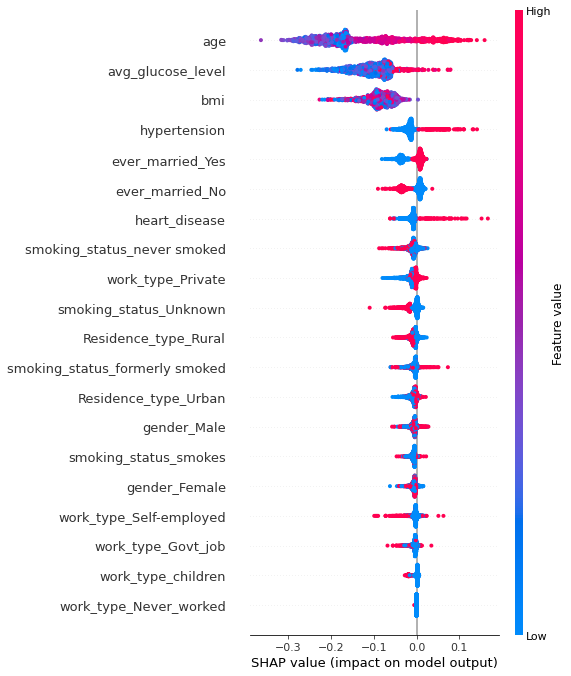

In [30]:
shap.summary_plot(shap_values[1], X_test)

**Description**: The summary_plot combines feature importance and feature effects into one visualization. Each point denotes a particular instance. The color denotes the feature value and the x-axis the SHAP value. The features are ordered according their importance (as described above).

**Interpretation**: Being younger (blue dots) seems to reduce the predicted risk of having a stroke (negative SHAP values). In contrast the SHAP values become more positive if the person is older (red dots).

## 4.2.2 Dependence Plots

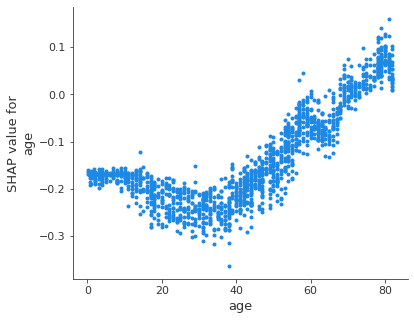

In [31]:
shap.dependence_plot(0, shap_values[1], X_test, interaction_index=None)

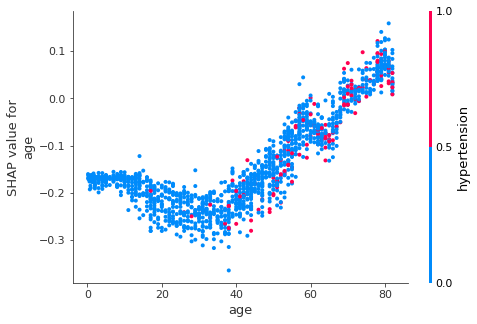

In [32]:
shap.dependence_plot(0, shap_values[1], X_test, interaction_index=1)

**Description**: The dependence_plot function provides an global overview of how the SHAP values differ for a certain feature (herer 'age') for all instances in the testing dataset. The second visualzation has an additonal y-axis which allows an overview on interaction between features.

**Interpretation**: Being younger than 40 years old lowers the prediction of having a stroke. From an age of around 40 years on the SHAP values increase linearly an become positive at around 70 year of age. Therfore being older than 70 years seems to increase the probability of having a risk which makes sense even from a non-domain-expert perspective. Looking at the second plot it can be seen that the number of persons having hypertension also increases slightly with the years of age.

# Literature

Molnar, C. (2022). Interpretable machine learning: A guide for making black box models explainable.